In [1]:
from DeepLabCutImplementation.model import PoseModel
from DeepLabCutImplementation.runners.train import PoseTrainingRunner
from DeepLabCutImplementation.runners.logger import CSVLogger
from DeepLabCutImplementation.runners.snapshots import TorchSnapshotManager

from DeepLabCutImplementation.data.utils import make_multianimal_labeled_image

from Wrappers.backbone import get_HRNetCoAM_backbone
from Wrappers.head import get_heatmap_head

from DeepLabCutImplementation.task import Task

import albumentations as A
from torch.utils.data import DataLoader
import torch
from torchvision.transforms import v2 as transforms

import logging
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [2]:
backbone = {
    "num_joints": 17,
    "att_heads": 1,
    "channel_att_only": False,
    "coam_modules": (2, ),
    "selfatt_coam_modules": None,
    "pretrained":False
}

bodypart_head = {
    "num_joints": 17,
    "channels": [48],
    "kernel_sizes": [],
    "kernel_size_final": 1,
    "strides": []
}

model = PoseModel(
            backbone=get_HRNetCoAM_backbone(**backbone),
            heads={
                "bodypart": get_heatmap_head(**bodypart_head),
            }
        )

path_to_model_checkpoint = "snapshot-best.pt",
model.load_state_dict(torch.load(path_to_model_checkpoint, weights_only=True)['model'])
model.cuda()

<All keys matched successfully>

In [3]:
inference_transforms = []

inference_transforms.append(
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        )

inference_transforms = A.Compose(
        inference_transforms,
        keypoint_params=A.KeypointParams(
            "xy", remove_invisible=False, label_fields=["class_labels"]
        ),
        bbox_params=A.BboxParams(format="coco", label_fields=["bbox_labels"]),
        )

In [4]:
from DeepLabCutImplementation.data.cocoloader import COCOLoader

# Configuration required by BUCTD for top_down_cropping and gen_sampling.
data_config = {
        "bbox_margin": 25,
        "colormode": "RGB",
        "inference": {
            "multithreading": {
                "enabled": True,
                "queue_length": 4,
                "timeout": 30,
            },
            "top_down_crop": {
                "width": 256,
                "height": 256,
                "crop_with_context": True,
            }
        },
        "train": {
            "top_down_crop": {
                "width": 256,
                "height": 256,
                "crop_with_context": False,
            },
        },
        "gen_sampling": {
            "keypoint_sigmas": 0.1,
        }
    }

data_loader = COCOLoader(
    project_root = "dataset/ap-10k",
    data_config = data_config,
    train_json_filename = "ap10k-train-split1.json",
    test_json_filename = "ap10k-test-split1.json",
)

In [5]:
test_dataset = data_loader.create_dataset(transform=inference_transforms, mode="test", task=Task.COND_TOP_DOWN)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [6]:
runner = PoseTrainingRunner(
    model=model,
    optimizer=None,
    device="cuda",
    snapshot_manager=TorchSnapshotManager(
            snapshot_prefix="snapshot",
            model_folder=Path("training_logs/snapshots"),
            key_metric="test.mAP",
            key_metric_asc=True,
            max_snapshots=5,
            save_epochs=5,
            save_optimizer_state=False,
    ),
    eval_interval=1,
    scheduler=None,
    logger=CSVLogger(train_folder="training_logs", log_filename="training_log.csv"),
    load_weights_only=True,
)

In [8]:
runner._epoch(test_dataloader, mode="eval")

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 14.57 GiB of which 4.75 MiB is free. Process 2423890 has 9.61 GiB memory in use. Process 2623133 has 4.95 GiB memory in use. Of the allocated memory 4.70 GiB is allocated by PyTorch, and 126.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [17]:
import matplotlib.pyplot as plt 
from matplotlib.colors import Colormap
import matplotlib.patches as patches

def make_multianimal_labeled_image(
    frame: np.ndarray,
    coords_truth: np.ndarray | list,
    coords_pred: np.ndarray | list,
    probs_pred: np.ndarray | list,
    colors: Colormap,
    dotsize: float | int = 12,
    alphavalue: float = 0.7,
    pcutoff: float = 0.6,
    labels: list = ["+", ".", "x"],
    ax: plt.Axes | None = None,
) -> plt.Axes:
    """
    Plots groundtruth labels and predictions onto the matplotlib's axes, with the specified graphical parameters.

    Args:
        frame: image
        coords_truth: groundtruth labels
        coords_pred: predictions
        probs_pred: prediction probabilities
        colors: colors for poses
        dotsize: size of dot
        alphavalue: transparency for the keypoints
        pcutoff: cut-off confidence value
        labels: labels to use for ground truth, reliable predictions, and not reliable predictions (confidence below cut-off value)
        ax: matplotlib plot's axes object

    Returns:
        matplotlib Axes object with plotted labels and predictions.
    """

    if ax is None:
        h, w, _ = np.shape(frame)
        _, ax = prepare_figure_axes(w, h)
    ax.imshow(frame, "gray")

    for n, data in enumerate(zip(coords_truth, coords_pred, probs_pred)):
        color = colors(n)
        coord_gt, coord_pred, prob_pred = data

        for i, coord in enumerate(coord_pred):
            if prob_pred[i] > pcutoff:
                plt.text(coord[0]-4, coord[1]+4, str(i+1), color="red", fontsize=5)

        reliable = np.repeat(prob_pred >= pcutoff, coord_pred.shape[1], axis=1)
        
        ax.plot(
            *coord_pred[reliable[:, 0]].T,
            labels[1],
            ms=dotsize,
            alpha=alphavalue,
            color=color,
        )
        
    return ax

/tmp/ipykernel_84451/185794866.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.cm.get_cmap("rainbow", num_pred),
/tmp/ipykernel_84451/185794866.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.cm.get_cmap("rainbow", num_pred),


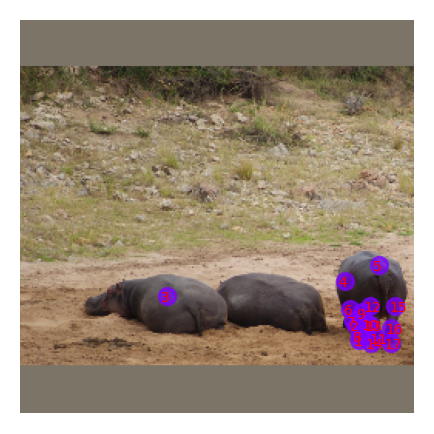

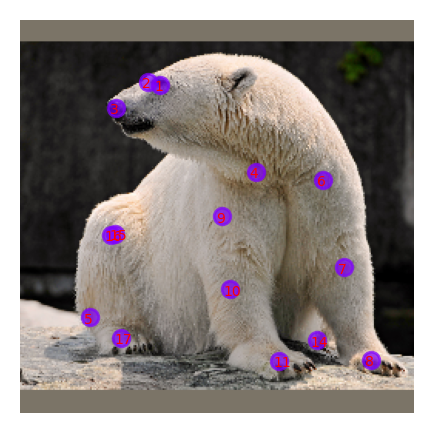

In [23]:
inv_normalize = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                 std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                            transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                 std = [ 1., 1., 1. ]),
                           ])

for i, batch in enumerate(test_dataloader):
    cond_kpts = batch["context"]["cond_keypoints"]

    outputs = model(batch["image"].cuda(), cond_kpts=cond_kpts)
    predictions = {
        name: {k: v.detach().cpu().numpy() for k, v in pred.items()}
        for name, pred in model.get_predictions(outputs).items()
    }

    ground_truth = batch["annotations"]["keypoints"]

    pred_bodyparts = predictions["bodypart"]["poses"][0]

    num_pred, num_keypoints = pred_bodyparts.shape[:2]

    frame = batch["image"][0]

    frame = inv_normalize(frame).permute(1,2,0)

    fig, ax = plt.subplots(frameon=False, dpi=200)
    ax.axis("off")
    ax.invert_yaxis()
    h, w, _ = np.shape(frame)
    fig.set_size_inches(w / 100, h / 100)
    ax.set_xlim(0, w)
    ax.set_ylim(0, h)
    ax.invert_yaxis()
    ax.imshow(frame, "gray")

    ax = make_multianimal_labeled_image(
            frame,
            ground_truth,
            pred_bodyparts[:, :, :2],
            pred_bodyparts[:,:,2:],
            plt.cm.get_cmap("rainbow", num_pred),
            12,
            0.7,
            0.1,
            ax=ax,
        )

    if i > 0:
        break